In [3]:
#Loading Unet and other libraries
from unet import simple_unet_model
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify

In [4]:
# Standard
import os
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Utils
import h5py

In [6]:
f = h5py.File(r"../Dataset_list/train_image_dataset.hdf5", "r")

In [7]:
frames2ch = f["train 2ch frames"][:,:,:,:]
masks2ch = f["train 2ch masks"][:,:,:,:]

In [8]:
from sklearn.model_selection import train_test_split
train_frames, test_frames, train_masks, test_masks = train_test_split(frames2ch, masks2ch)

In [9]:
print(train_frames.shape)
print(test_frames.shape)

(600, 256, 256, 1)
(200, 256, 256, 1)


In [10]:
IMG_HEIGHT = train_frames.shape[1]
IMG_WIDTH  = train_frames.shape[2]
IMG_CHANNELS = train_frames.shape[3]

In [11]:
print(IMG_HEIGHT)

256


In [9]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


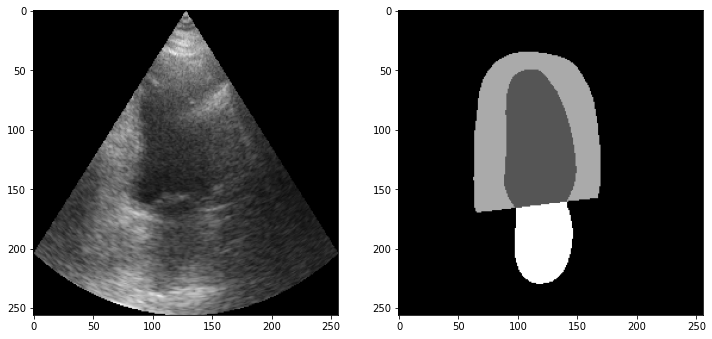

In [10]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(train_frames))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(train_frames[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(train_masks[image_number], (256, 256)), cmap='gray')
plt.show()

In [11]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=0,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

In [12]:
mask_data_gen_args = dict(rotation_range=0,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

In [13]:
#Generator for training data
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(train_frames, augment=True, seed=seed)

In [14]:
#Generator for training data
image_generator = image_data_generator.flow(train_frames, seed=seed)
valid_img_generator = image_data_generator.flow(test_frames, seed=seed)

In [15]:
#Generator for masking data
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(train_masks, augment=True, seed=seed)

In [16]:
#Generator for masking data
mask_generator = mask_data_generator.flow(train_masks, seed=seed)
valid_mask_generator = mask_data_generator.flow(test_masks, seed=seed)

In [17]:
#generating Image mask
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [18]:
#Using above function to generate
my_generator = my_image_mask_generator(image_generator, mask_generator)

In [19]:
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [20]:
x = image_generator.next()
y = mask_generator.next()

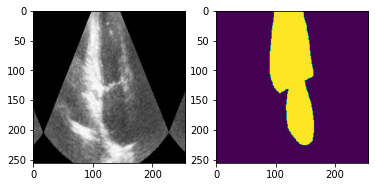

In [21]:
#Sanity check, view few images
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [22]:
batch_size = 16
steps_per_epoch = 3*(len(train_frames))//batch_size

In [25]:
#Model training
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, epochs=50)

Epoch 1/50
112/112 [==============================] - 1707s 15s/step - loss: 0.6927 - accuracy: 0.7182 - val_loss: 0.4327 - val_accuracy: 0.7311
Epoch 2/50
112/112 [==============================] - 1694s 15s/step - loss: 0.4237 - accuracy: 0.7376 - val_loss: 0.4269 - val_accuracy: 0.7313
Epoch 3/50
112/112 [==============================] - 1696s 15s/step - loss: 0.4232 - accuracy: 0.7388 - val_loss: 0.4200 - val_accuracy: 0.7342
Epoch 4/50
112/112 [==============================] - 1697s 15s/step - loss: 0.4142 - accuracy: 0.7392 - val_loss: 0.4173 - val_accuracy: 0.7325
Epoch 5/50
112/112 [==============================] - 1704s 15s/step - loss: 0.4150 - accuracy: 0.7412 - val_loss: 0.4186 - val_accuracy: 0.7340
Epoch 6/50
112/112 [==============================] - 1699s 15s/step - loss: 0.4126 - accuracy: 0.7402 - val_loss: 0.4191 - val_accuracy: 0.7314
Epoch 7/50
112/112 [==============================] - 1686s 15s/step - loss: 0.4101 - accuracy: 0.7390 - val_loss: 0.3955 - val_ac

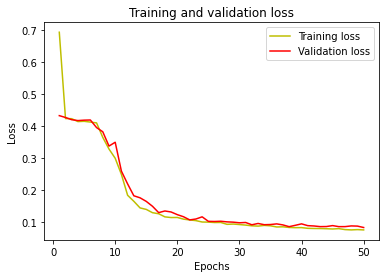

In [26]:
#Plotting training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

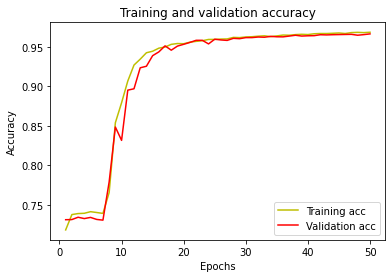

In [27]:
#Plotting training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
#model saving
model.save_weights("../Trained_Model/unet_2ch.h5")